In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install h5py

In [3]:
import os
from tqdm import tqdm
from google.colab import files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageEnhance

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D,
    concatenate, BatchNormalization, Activation, LeakyReLU
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dense, Conv2DTranspose, UpSampling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, UpSampling2D, Dropout

from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1_l2

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import h5py

In [4]:
import h5py

# Caminho para o arquivo HDF5 no Google Drive
file_path = '/content/drive/MyDrive/PROJETO/g5_dataset_augmented_processed_28_ago.h5'

# Carregando os arrays do arquivo HDF5
with h5py.File(file_path, 'r') as h5f:
    X_train_processed = h5f['x_train'][:]
    X_test_processed = h5f['x_test'][:]
    y_train_reduced = h5f['y_train'][:]
    y_test_reduced = h5f['y_test'][:]

In [5]:
X_train_processed.shape, X_test_processed.shape, y_train_reduced.shape, y_test_reduced.shape

((9570, 128, 128, 3),
 (798, 128, 128, 3),
 (9570, 128, 128, 3),
 (798, 128, 128, 3))

In [68]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

y_train_reduced[np.all(y_train_reduced == [255, 0, 0], axis=-1)] = [255, 255, 255]
y_test_reduced[np.all(y_test_reduced == [255, 0, 0], axis=-1)] = [255, 255, 255]

def mask_to_bbox(mask):
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]
    return [x_min, y_min, x_max, y_max]

y_train = np.array([mask_to_bbox(mask) for mask in y_train_reduced])
y_test = np.array([mask_to_bbox(mask) for mask in y_test_reduced])

def create_model():
    model = models.Sequential()

    model.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(8, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(10, activation=LeakyReLU(alpha=0.01)))

    model.add(layers.Dense(4, activation='relu'))

    return model

model = create_model()

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
]

history = model.fit(X_train_processed, y_train, epochs=60, batch_size=32,
                    validation_data=(X_test_processed, y_test), callbacks=callbacks)


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_87 (Conv2D)          (None, 126, 126, 4)       112       
                                                                 
 max_pooling2d_86 (MaxPooli  (None, 63, 63, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_88 (Conv2D)          (None, 61, 61, 8)         296       
                                                                 
 max_pooling2d_87 (MaxPooli  (None, 30, 30, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_89 (Conv2D)          (None, 28, 28, 16)        1168      
                                                                 
 max_pooling2d_88 (MaxPooli  (None, 14, 14, 16)      

In [71]:
model.save('bounding-box-cabeca.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 0s 4ms/step


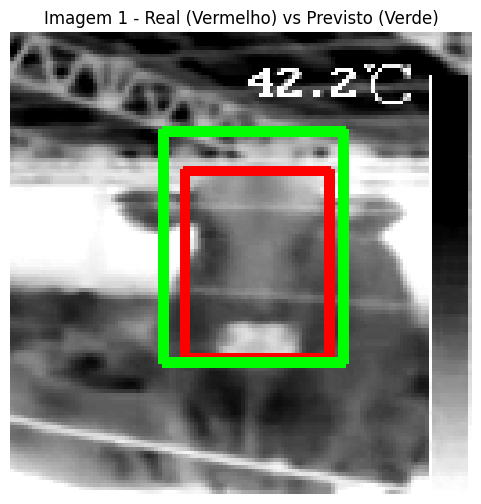

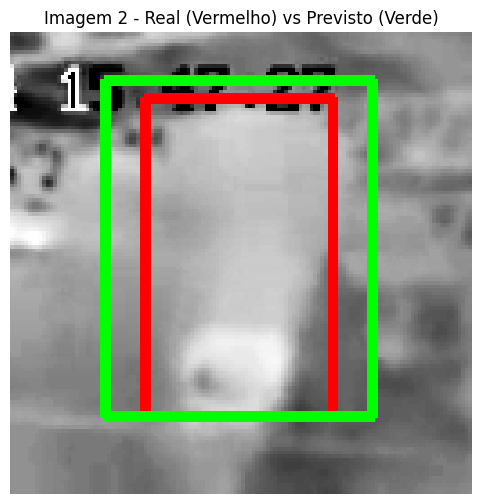

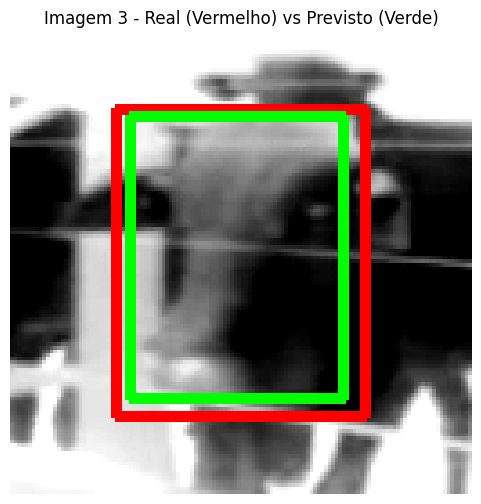

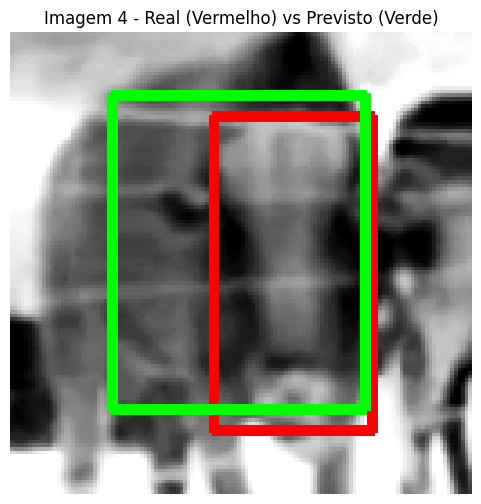

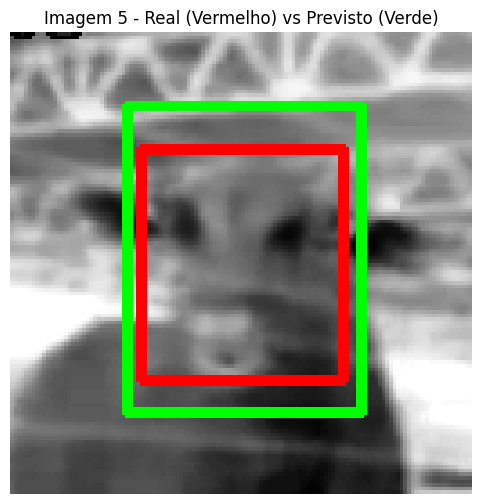

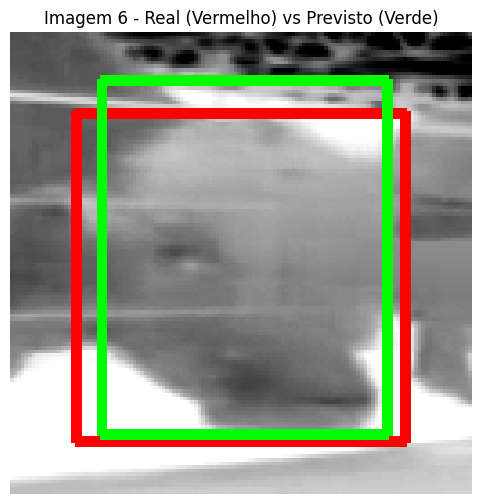

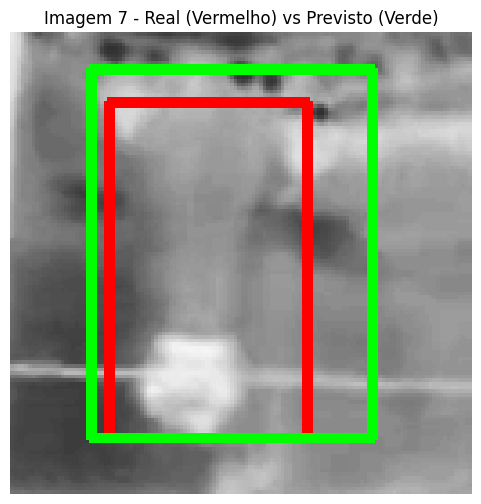

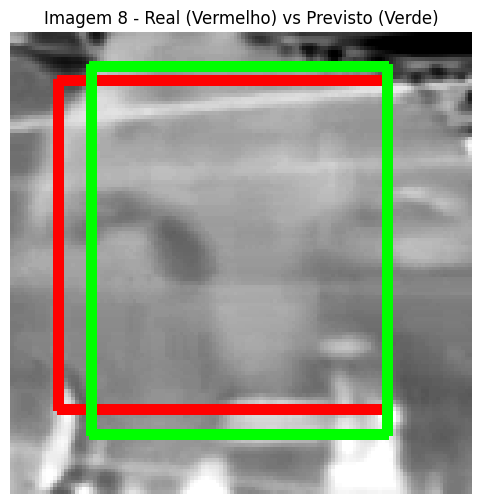

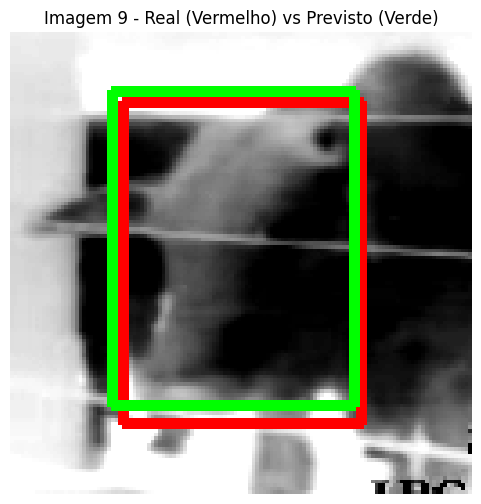

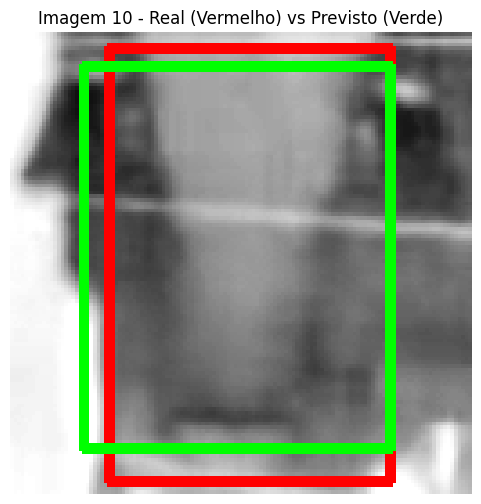

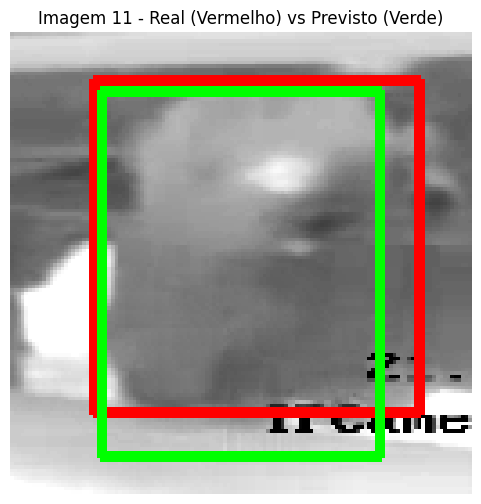

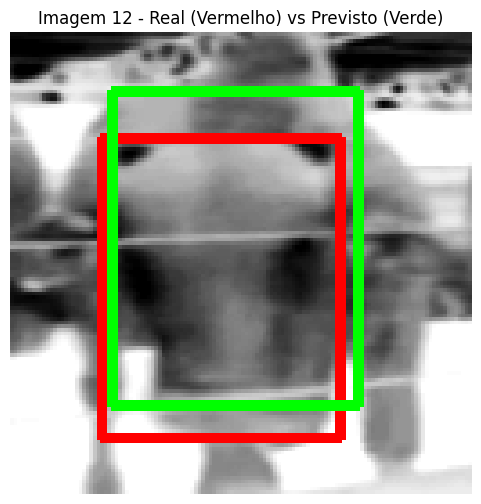

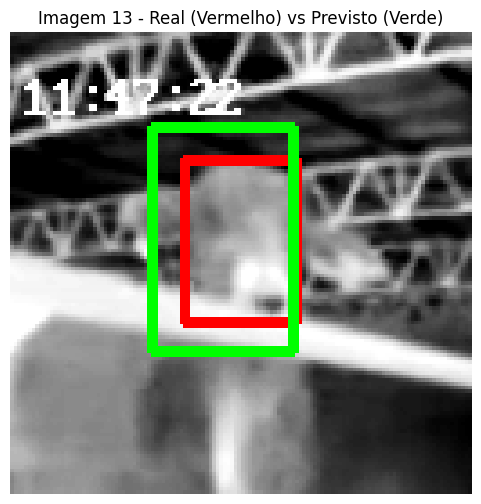

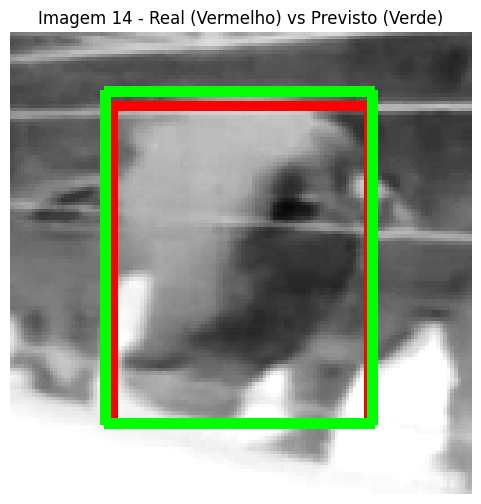

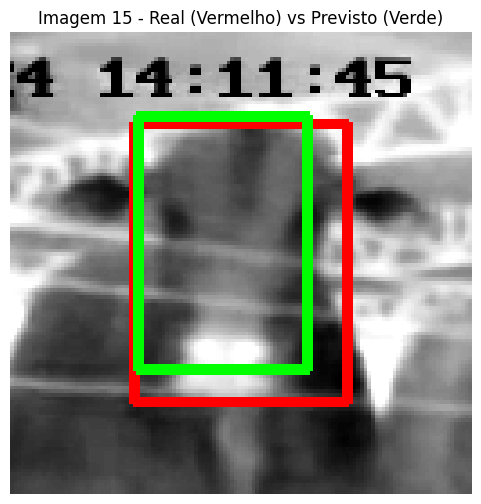

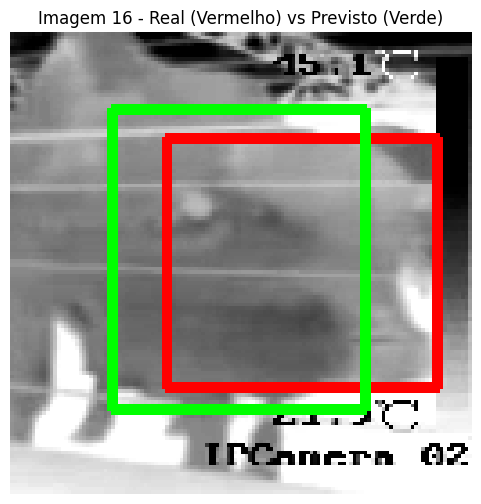

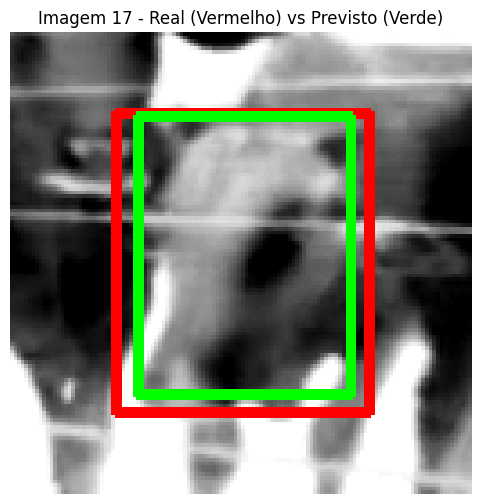

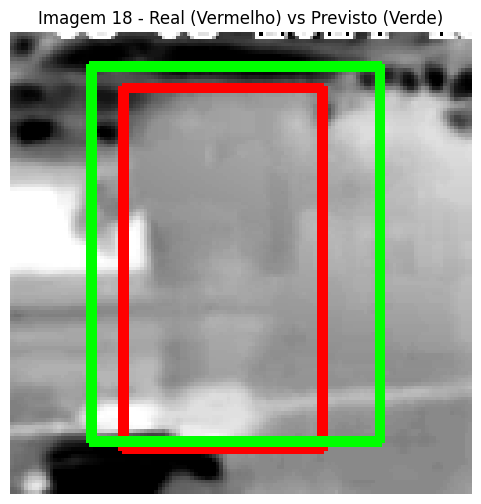

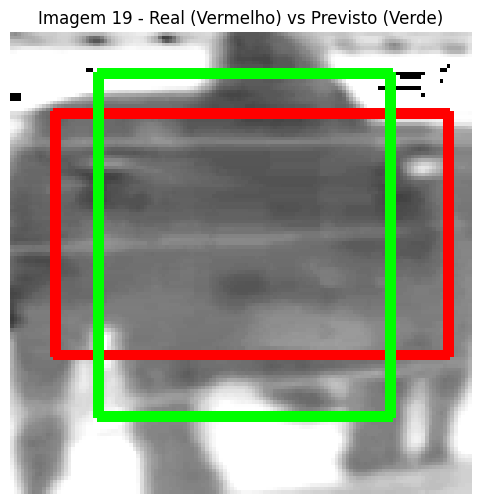

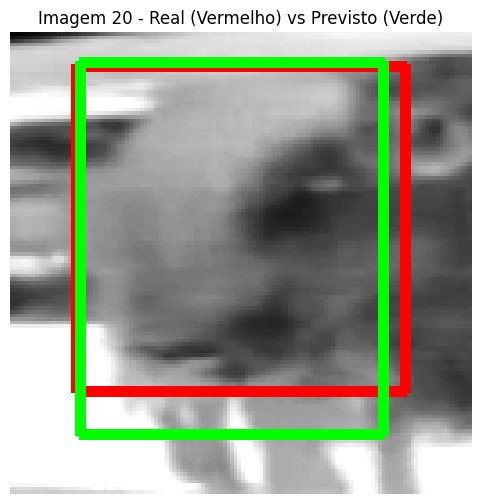

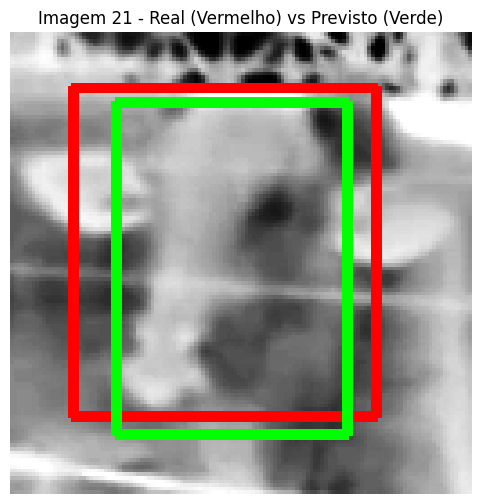

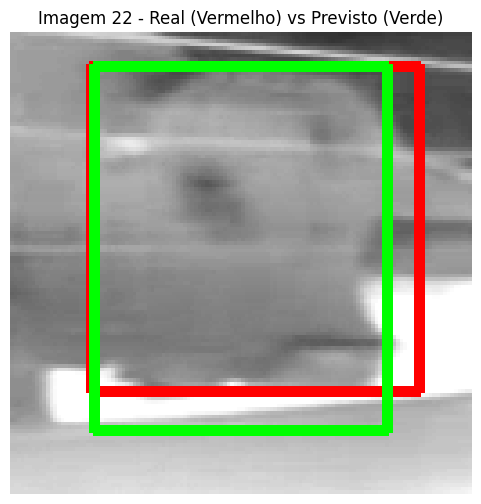

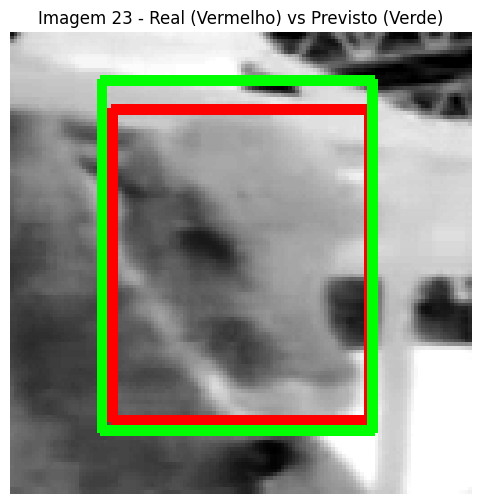

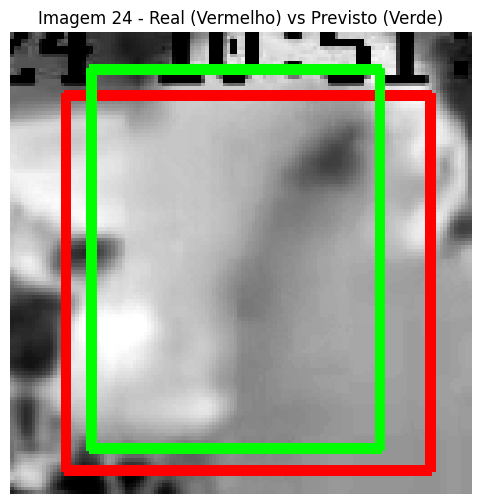

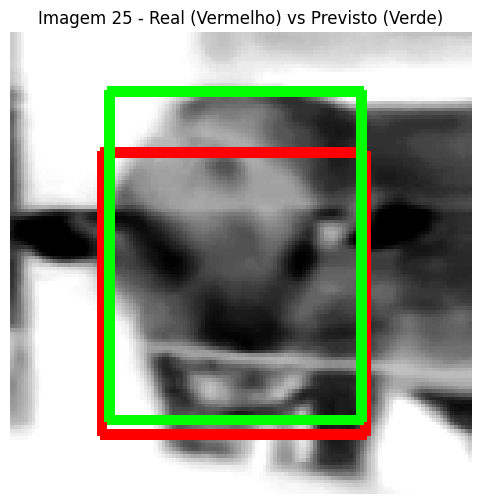

In [69]:
import matplotlib.pyplot as plt
import cv2

def draw_bbox(image, bbox, color=(0, 255, 0), thickness=2):
    x_min, y_min, x_max, y_max = bbox
    return cv2.rectangle(image.copy(), (x_min, y_min), (x_max, y_max), color, thickness)

y_pred = model.predict(X_test_processed)

num_images_to_show = 25
for i in range(num_images_to_show):
    image = X_test_processed[i]
    bbox_real = y_test[i]
    bbox_pred = y_pred[i].astype(int)
    image_with_real_bbox = draw_bbox(image, bbox_real, color=(255, 0, 0))
    image_with_pred_bbox = draw_bbox(image_with_real_bbox, bbox_pred, color=(0, 255, 0))

    plt.figure(figsize=(6, 6))
    plt.imshow(image_with_pred_bbox)
    plt.title(f"Imagem {i+1} - Real (Vermelho) vs Previsto (Verde)")
    plt.axis('off')
    plt.show()


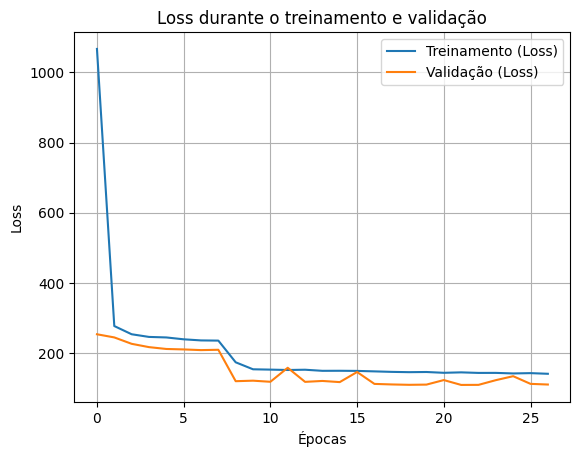

In [70]:
import matplotlib.pyplot as plt

# Função para plotar o gráfico de loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Treinamento (Loss)')
    plt.plot(history.history['val_loss'], label='Validação (Loss)')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Loss durante o treinamento e validação')
    plt.grid(True)
    plt.show()

# Plotando o gráfico de loss
plot_loss(history)
